ผมจะยกตัวอย่างการทำงานของทั้ง 5 ขั้นตอนดังนี้
1. Create a Question (ตั้งโจทย์ว่าเราอยากทำอะไร ต้องหาข้อมูลอะไร ต้องวิเคราะห์รูปแบบไหน)
2. Extract Data (หาข้อมูล)
3. Data Preparation + Data Cleansing (จัดเตรียมข้อมูลในมีความเหมาะสม)
4. Data Analyst (วิเคราะห์ข้อมูล)
5. Presentation (นำเสนอข้อมูล)
---

# 1. Create a Question

โจทย์ :  Youtube ช่อง gssspotted คอมเม้นส่วนใหญ่มาแนวโน้มจะ toxic หรือไม่  <br>
ในตัวอย่างจะขอทำแค่คลิป "สิ่งมหัศจรรย์สิ่งที่ 8 ของโลก (บ้านเอียง) | นิทานก่อนนอนกับลุงไนท์" -> https://www.youtube.com/watch?v=pxFYvpSIVXI 


จากโจทย์ทำให้ผมคิดเป็นขั้นตอนดังนี้ (ทำจริงอาจจะไม่เหมือนก็ได้นะ มันเหมือนฟิลวางแผนคร่าวๆให้เราเห็นภาพรวมของงาน)
1. แหล่งข้อมูลที่ต้องหาคือ Youtube ช่อง gssspotted
2. อยากรู้ว่าคอมเม้น toxic หรือไม่ ต้องมีการเก็บข้อมูลเกี่ยวกับ"การแสดงความเห็น" เป็นหลัก
3. จะได้ข้อมูลมามี Web scraping ด้วยตนเอง, API (ใช้วิธีนี้ในรอบนี้),ใช้ tools 
3. นอกจากนั้นเราต้องมีการ Label เพิ่มเติมว่าข้อมูลดังกล่าวเป็นข้อความประเภทใด เช่น positive, negative, neutral
4. จะ label ข้อ 3 มีวิธีสองวิธีคร่าวๆคือทำเอง และให้ Generative AI (Bard, ChatGPT, etc.)
5. หลังจากได้ข้อมูลเราควร Clean data ด้วยนะ ซึ่งในที่นี้คงทำเพียงคัดแยกความเห็นที่ดูมีท่าทางเป็นสแปม
6. ลอง plot ข้อมูลคร่าวๆก่อนไปทำ Dashboard 
7. ไปทำ Dashboard ด้วย Looker Studio ละกัน เพราะว่า `FREE`
---

# 2. Extract Data

$ pip install --upgrade google-api-python-client

$ pip install --upgrade google-auth-oauthlib google-auth-httplib2

In [1]:
# Documentation 
# https://developers.google.com/youtube/v3/getting-started
# https://developers.google.com/youtube/v3/docs/commentThreads/list 

import os
import googleapiclient.discovery

os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = "YOUR_API_KEY" # ทำตามคลิปนี้ได้เลย https://www.youtube.com/watch?v=XTjtPc0uiG8

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey = DEVELOPER_KEY)

request = youtube.commentThreads().list(
    part = 'id,replies,snippet' ,
    videoId = 'pxFYvpSIVXI', # จากโจทย์ https://www.youtube.com/watch?v=pxFYvpSIVXI ดูไอดีได้ตรง v={videoId}
    maxResults = 100 # ได้มากสุดแค่ 100 comments ถ้าอยากได้มากกว่านี้ต้องเขียนเพิ่มเช่น https://stackoverflow.com/questions/65762711/youtube-data-api-how-to-extract-more-than-100-comments 
)
response = request.execute()

In [4]:
print(response)

{'kind': 'youtube#commentThreadListResponse', 'etag': '9zgg1TXGMiCptvcxmq1h0d1XDcc', 'nextPageToken': 'QURTSl9pMlBMT3JybHZFcDVsU3dibE5VRU9CUVVCbUdvSmlxazZKNWp1cFEwQjFSbDBJZ19SdmFZRTZWMWtoQXVQRXdXUlhKUEFwRzVMaw==', 'pageInfo': {'totalResults': 100, 'resultsPerPage': 100}, 'items': [{'kind': 'youtube#commentThread', 'etag': 'zd5g7ITcbFzuieeYK_NNzAiROhk', 'id': 'Ugzr_yOCToZ7f31vDet4AaABAg', 'snippet': {'channelId': 'UC8uxFKMADMhYn80nkfpPa-w', 'videoId': 'pxFYvpSIVXI', 'topLevelComment': {'kind': 'youtube#comment', 'etag': 'd94rz1Wi8gn_zbaa2xgz-GUa9HU', 'id': 'Ugzr_yOCToZ7f31vDet4AaABAg', 'snippet': {'channelId': 'UC8uxFKMADMhYn80nkfpPa-w', 'videoId': 'pxFYvpSIVXI', 'textDisplay': 'งาดวัดมีแมงปอทอดขายนะคะเผื่อใครอยากลอง😂😂😂', 'textOriginal': 'งาดวัดมีแมงปอทอดขายนะคะเผื่อใครอยากลอง😂😂😂', 'authorDisplayName': 'Monthita', 'authorProfileImageUrl': 'https://yt3.ggpht.com/ytc/APkrFKb2xBi43ffK4Lycpzwg7pzJMgG1lJETxE4HqT6sQw=s48-c-k-c0x00ffffff-no-rj', 'authorChannelUrl': 'http://www.youtube.com/chan

In [5]:
# จะเห็นว่ามี 100 คอมเม้นตามตัวแปร maxResults ที่ตั้งไว้
len(response['items'])

100

In [6]:
import pandas as pd

name = []
text = []
for i in response['items']:
    authorDisplayName = i['snippet']['topLevelComment']['snippet']['authorDisplayName']
    textDisplay = i['snippet']['topLevelComment']['snippet']['textDisplay']
    name.append(authorDisplayName)
    text.append(textDisplay)

df =pd.DataFrame({'Name':name, 'Comments':text})
df.head(10)

,Name,Comments
0,Monthita,งาดวัดมีแมงปอทอดขายนะคะเผื่อใครอยากลอง😂😂😂
1,CHEN PUNCH,เสื้อผ้าพี่สวยมากซื้อที่ไหนครับ
2,sper,บ้านโสโครก
3,นายเต้า' หู้,เป็นผู้ชายที่บูลลี่คนเมืองเก่งจัด5555
4,DEWZAZEBb lol,พี่เจมส์แนวเพื่อนผมเลยพูดไปเรื่อยชิบหายไม่ได้ว...
5,ธนกฤต ณ พัทลุง,ศั ก ดิ์ ศ รี
6,Chaiyasak ploysangsai,👍
7,น็อต มา,ผมอยากเห็นลุงไนท์เล่นเกมRaknarok จังเลย รอดูนะ
8,zeno,รู้แล้วทำไมเรียกบ้านขยะะะะ ของจิงงงงงง55555555...
9,New Era,ค้นหาลุงไนท์เล่าเรื่องผี เจอคลิปนี้ขึ้นมาในสาม...


In [7]:
# คอมเม้นเป็นลิ้งคือเขาแปะช่วงเวลานั้นๆที่เขาสนใจในคลิปกันเฉยๆหนะ อย่างเช่นอันนี้ก็คือลิ้งไประยะเวลาที่ 1.42.29 ของคลิป
print(df[df['Name']=='ูLightvan007']['Comments'].values[0])

<a href="https://www.youtube.com/watch?v=pxFYvpSIVXI&amp;t=1h42m29s">1:42:29</a> เสามงคล😂


---

# 3. Data Preparation + Data Cleansing

เดียวทำ Cleanตัวที่เป็นลิ้งออก

In [8]:
df.head(10)

,Name,Comments
0,Monthita,งาดวัดมีแมงปอทอดขายนะคะเผื่อใครอยากลอง😂😂😂
1,CHEN PUNCH,เสื้อผ้าพี่สวยมากซื้อที่ไหนครับ
2,sper,บ้านโสโครก
3,นายเต้า' หู้,เป็นผู้ชายที่บูลลี่คนเมืองเก่งจัด5555
4,DEWZAZEBb lol,พี่เจมส์แนวเพื่อนผมเลยพูดไปเรื่อยชิบหายไม่ได้ว...
5,ธนกฤต ณ พัทลุง,ศั ก ดิ์ ศ รี
6,Chaiyasak ploysangsai,👍
7,น็อต มา,ผมอยากเห็นลุงไนท์เล่นเกมRaknarok จังเลย รอดูนะ
8,zeno,รู้แล้วทำไมเรียกบ้านขยะะะะ ของจิงงงงงง55555555...
9,New Era,ค้นหาลุงไนท์เล่าเรื่องผี เจอคลิปนี้ขึ้นมาในสาม...


In [9]:
import os 
save_path = os.path.join(os.getcwd(), 'comments.xlsx')
df.to_excel(save_path, index=False) 

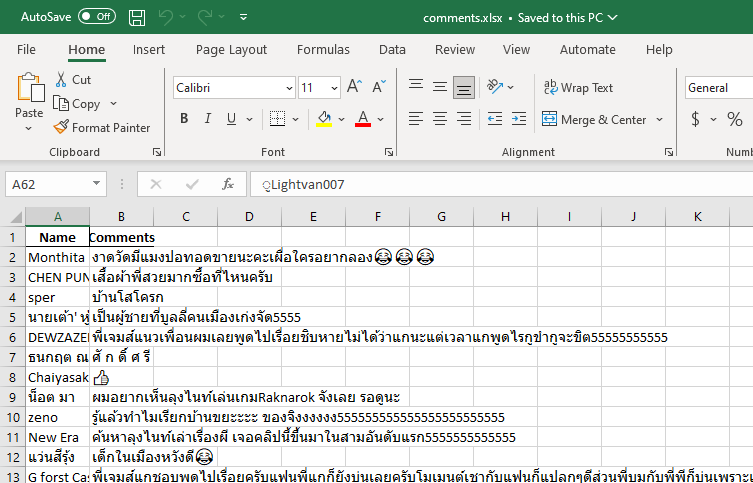

จากข้อมูลที่เซฟออกไปจะเห็นว่าข้อความต่างๆไม่จำเป็นต้องทำ Cleansing data ดังนั้นจึงข้ามขั้นตอนนี้ไป (API เขาดึงข้อมูลใดๆมาสวยงามอยู่แล้วหนะ) <br>
เราเลยเหลือเพียงขั้นตอน Preparation data ซึ่งเราตั้งใจว่าอยากดู Sentiment analysis ดังนั้นเราต้อง Label เพิ่มอีก 1 column (Data: positive, negative, neutral) <br><br>

โดยในขั้นตอนดังกล่าวทำได้หลากหลายวิธีเช่น <br>
1. หา AI สักตัวนึงที่สามารถทำ Sentiment analysis ข้อความที่มี(ภาษาไทย)ได้ <br>
2. ใช้ Generative AI (Bard, Chatgpt, etc.) ให้ช่วยเพิ่มข้อมูลให้  -> ลองดูวิธีการผ่านลิ้งนี้ได้ [DataRockie](https://datarockie.com/blog/sentiment-analysis-bard-ai/)
3. ทำเองเลย กดสร้าง column เพิ่มมาอันนึงแล้วใส่เองโลด <br>

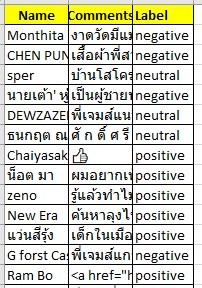 <br>
ซึ่งผมขอทำสุ่มๆไปก่อนนะครับ ไมได้เป็นการวางรายละเอียดให้ถูกต้อง 100% 

---

# 4. Data Analyst (วิเคราะห์ข้อมูล)

In [11]:
import pandas as pd
df = pd.read_excel(os.path.join(os.getcwd(), 'comments.xlsx'))
df.head(10)

,Name,Comments,Label
0,Monthita,งาดวัดมีแมงปอทอดขายนะคะเผื่อใครอยากลอง😂😂😂,negative
1,CHEN PUNCH,เสื้อผ้าพี่สวยมากซื้อที่ไหนครับ,negative
2,sper,บ้านโสโครก,neutral
3,นายเต้า' หู้,เป็นผู้ชายที่บูลลี่คนเมืองเก่งจัด5555,negative
4,DEWZAZEBb lol,พี่เจมส์แนวเพื่อนผมเลยพูดไปเรื่อยชิบหายไม่ได้ว...,neutral
5,ธนกฤต ณ พัทลุง,ศั ก ดิ์ ศ รี,neutral
6,Chaiyasak ploysangsai,👍,positive
7,น็อต มา,ผมอยากเห็นลุงไนท์เล่นเกมRaknarok จังเลย รอดูนะ,positive
8,zeno,รู้แล้วทำไมเรียกบ้านขยะะะะ ของจิงงงงงง55555555...,positive
9,New Era,ค้นหาลุงไนท์เล่าเรื่องผี เจอคลิปนี้ขึ้นมาในสาม...,positive


In [26]:
count_sentiment_df  = df.groupby('Label').count().reset_index()[['Label','Name']].rename(columns={"Name": "Count"})
count_sentiment_df.head()

,Label,Count
0,negative,10
1,neutral,35
2,positive,55


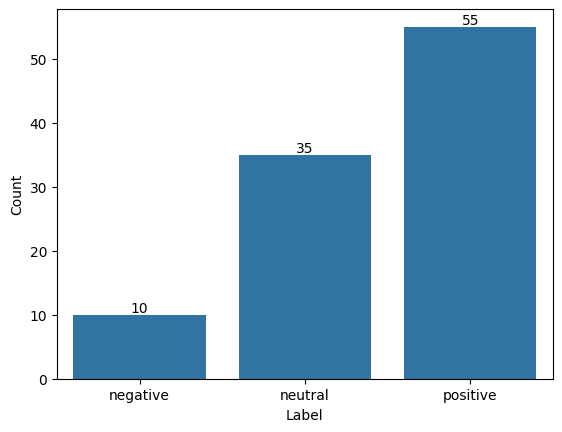

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=count_sentiment_df['Label'], y=count_sentiment_df['Count'])

for i, v in enumerate(count_sentiment_df['Count']):
    plt.text(i, v, str(v), ha='center', va='bottom')


งาดวัดมีแมงปอทอดขายนะคะเผื่อใครอยากลอง😂😂😂เสื้อผ้าพี่สวยมากซื้อที่ไหนครับบ้านโสโครกเป็นผู้ชายที่บูลลี่คนเมืองเก่งจัด5555พี่เจมส์แนวเพื่อนผมเลยพูดไปเรื่อยชิบหายไม่ได้ว่าแกนะแต่เวลาแกพูดไรกูขำกูจะขิต55555555555ศั ก ดิ์ ศ รี👍ผมอยากเห็นลุงไนท์เล่นเกมRaknarok จังเลย รอดูนะรู้แล้วทำไมเรียกบ้านขยะะะะ ของจิงงงงงง555555555555555555555555ค้นหาลุงไนท์เล่าเรื่องผี เจอคลิปนี้ขึ้นมาในสามอันดับแรก5555555555555เด็กในเมืองหวังดี😂พี่เจมส์แกชอบพูดไปเรื่อยครับแฟนพี่แกก็ยังบ่นเลยครับโมเมนต์เชากับแฟนก็แปลกๆดีส่วนพี่บูมกับพี่พีก็บ่นเพราะแกพูดไปเรื่อยแกเลยเหงาครับบางทีว่างๆโทรไปหามั่วเลยพี่เปาihave รัชโย พาสุ พี่พี พี่บูม เบรกเกตหรือคุณยูครับพี่แกเอาฮาเกิ้นพูดไปเรื่อยจริงๆครับแฟนคลับอย่างผมคือยังเอือม5555เป็นโรคอยากจะพูดอะไรก็พูดไม่เกี่ยวกันเลย5555<a href="https://www.youtube.com/watch?v=pxFYvpSIVXI&amp;t=6m40s">6:40</a> ผมอยู่สัตหีบ คอนโดผม แมงปอเต็มเลย ช่วงผสมพันธุ์แม่งบินเต็มคอนโดเลย555555มีน้องที่ออฟฟิศเป็นคนอีสาน (อุดร) พูดไปเรื่อยมากจริง พูดได้ทั้งวัน 555555เป็นการคอลแลบที่ไม่คิดว่าจะได้เห็น แต่คอลแลบแล้

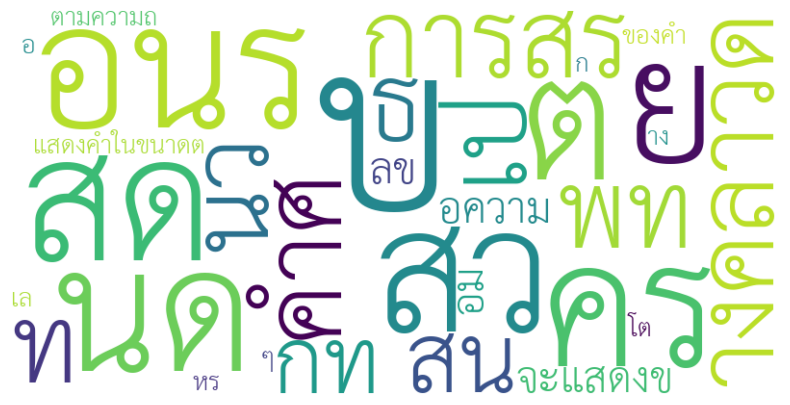

In [38]:
import wordcloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS

thai_texttext = ""
for i,j in df.iterrows():
    thai_texttext += j["Comments"]
print(thai_texttext)

# Create a WordCloud object with Thai font support
wordcloud_obj = wordcloud.WordCloud(width=800, height=400, background_color='white', font_path="D:\Learn\SocialListening_TH\THSarabunNew.ttf")

# Remove common Thai stopwords
stopwords = set(STOPWORDS)
stopwords.update(["ครับ", "ยินดี", "การ", "เป็น", "ที่"])

# Generate the word cloud
wordcloud_img = wordcloud_obj.generate(thai_text)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_img, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.show()
